In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle

## Load trees from results directory

In [3]:
results = sorted([x for x in glob.glob("../nextflow/results/*") if not x.endswith("smartseq-singularity")])[-1]
results

'../nextflow/results/2022-05-04'

In [4]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 77 GC trees


## Data frame with a row for each edge on each tree, excluding 10-week mice
Exclude root and leaves

In [5]:
rows = []
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        if (not node.is_root()) and (node.abundance > 1 or not node.is_leaf()):
            delta_delta_bind = node.delta_bind_CGG - node.up.delta_bind_CGG
            delta_delta_expr = node.delta_expr - node.up.delta_expr
            polytomy_degree = len(node.children) + node.abundance
            rows.append([gc, node.name, node.get_distance(tree.tree), node.abundance, polytomy_degree, node.LBI, node.LBR, node.delta_bind_CGG, node.up.delta_bind_CGG, delta_delta_bind, node.delta_expr, delta_delta_expr])
df = pd.DataFrame(rows, columns=["GC", "name", "divergence", "abundance", "polytomy degree", "LBI", "LBR", "affinity", "parent affinity", r"parent edge $\Delta$ affinity", "expression", r"parent edge $\Delta$ expression"])

# no 10-week
df = df.loc[~df.GC.str.startswith("mouse7") & ~df.GC.str.startswith("mouse8")]

# rank transforms
df["polytomy degree rank"] = df["polytomy degree"].rank()
df["LBI rank"] = df.LBI.rank()
df["LBR rank"] = df.LBR.rank()
df["affinity rank"] = df.affinity.rank()
df[r"parent edge $\Delta$ affinity rank"] = df[r"parent edge $\Delta$ affinity"].rank()

df

,GC,name,divergence,abundance,polytomy degree,LBI,LBR,affinity,parent affinity,parent edge $\Delta$ affinity,expression,parent edge $\Delta$ expression,polytomy degree rank,LBI rank,LBR rank,affinity rank,parent edge $\Delta$ affinity rank
0,mouse1_GC1,seq56,1.0,1,2,5.252151,0.223615,-0.80796,0.00000,-0.80796,-0.15104,-0.15104,485.0,713.0,268.0,39.0,49.0
1,mouse1_GC1,1,4.0,0,2,3.107390,1.669774,-7.71074,0.00000,-7.71074,-0.77924,-0.77924,485.0,239.0,1368.0,1.0,1.0
2,mouse1_GC1,17,1.0,0,10,18.789397,3.377441,0.33100,0.00000,0.33100,-0.00561,-0.00561,1639.0,1679.0,1601.0,477.5,1351.0
3,mouse1_GC1,seq14,3.0,1,2,4.452909,0.306784,0.81725,0.33100,0.48625,-0.01130,-0.00569,485.0,536.0,392.0,925.0,1423.0
4,mouse1_GC1,8,5.0,0,2,3.257721,1.457129,1.17254,0.33100,0.84154,-0.04044,-0.03483,485.0,268.0,1299.0,1320.0,1570.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,mouse6_GC77,seq4,4.0,2,2,3.413270,0.059053,0.96027,0.96027,0.00000,-1.15282,0.00000,485.0,315.0,26.0,1077.5,720.0
1727,mouse6_GC77,13,7.0,0,2,4.901133,0.606272,0.75399,0.76696,-0.01297,-0.72151,-0.10773,485.0,642.0,770.0,849.0,383.5
1728,mouse6_GC77,seq9,12.0,2,2,1.203381,0.187872,-0.00518,1.19398,-1.19916,-0.31626,-0.24044,485.0,3.0,202.0,141.0,27.0
1729,mouse6_GC77,seq2,8.0,3,4,2.630413,0.535734,1.08960,1.19398,-0.10438,-0.12466,-0.04884,1344.5,137.0,690.0,1217.0,180.0


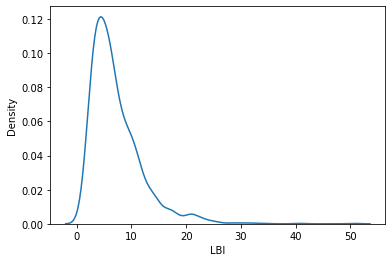

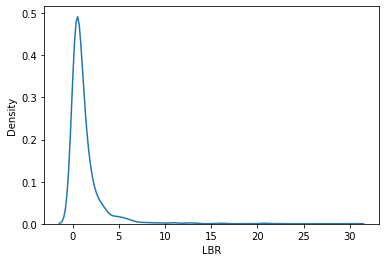

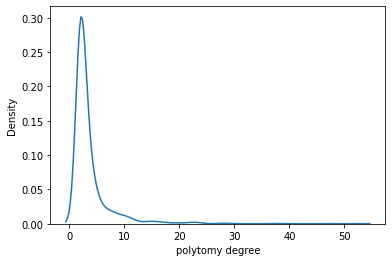

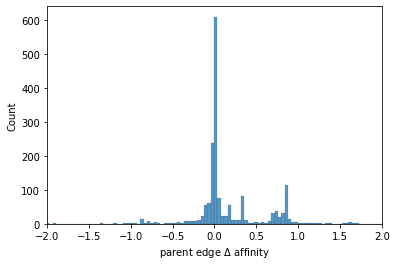

In [6]:
sns.kdeplot(data=df, x="LBI")
plt.show()

sns.kdeplot(data=df, x="LBR")
plt.show()

sns.kdeplot(data=df, x="polytomy degree")
plt.show()

sns.histplot(data=df, x=r"parent edge $\Delta$ affinity")
plt.xlim(-2, 2)
plt.show()

In [9]:
thresh = 10
df["burst"] = df.LBI >= thresh

df = df.sort_values("LBI")

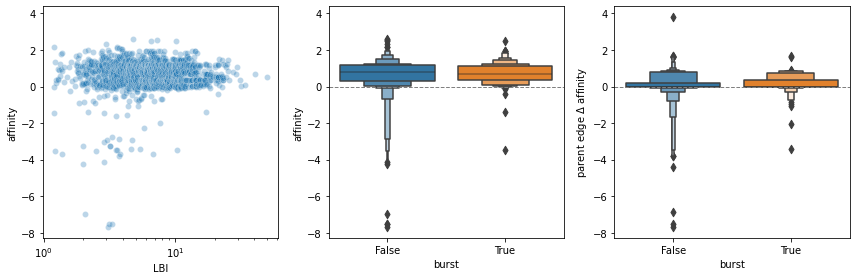

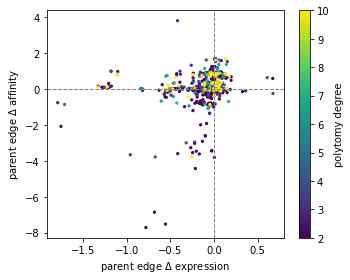

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
g = sns.scatterplot(data=df, y=r"affinity", x="LBI", alpha=0.3)
plt.axvline(0, c="grey", ls="--", lw=1)
plt.xscale("log")

plt.subplot(132, sharey=g)
sns.boxenplot(data=df, y=r"affinity", x="burst")
plt.axhline(0, c="grey", ls="--", lw=1)

plt.subplot(133, sharey=g)
sns.boxenplot(data=df, y=r"parent edge $\Delta$ affinity", x="burst")
plt.axhline(0, c="grey", ls="--", lw=1)

plt.tight_layout()
plt.savefig("output/plots/affinity-fitness.polytomy_degree_Vs_bind.pdf")
plt.show()

plt.figure(figsize=(5, 4))
plt.scatter(x=df[r"parent edge $\Delta$ expression"], y=df[r"parent edge $\Delta$ affinity"],
            c=df["polytomy degree"],
            s=5,
            vmax=10,
           )
plt.axvline(0, c="grey", ls="--", lw=1)
plt.axhline(0, c="grey", ls="--", lw=1)
plt.ylabel(r"parent edge $\Delta$ affinity")
plt.xlabel(r"parent edge $\Delta$ expression")
plt.colorbar(label="polytomy degree")

plt.tight_layout()
plt.savefig("output/plots/affinity-fitness.scatter.pdf")
plt.show()

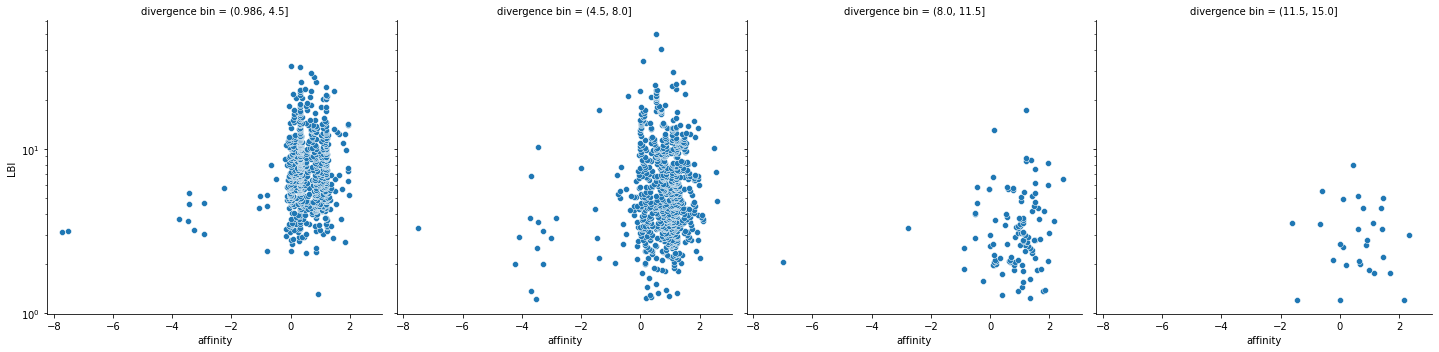

In [20]:
df["divergence bin"] = pd.cut(df.divergence, 4)

# plt.figure(figsize=(5, 2))
# sns.boxplot(data=df, y=r"affinity", x="divergence bin", hue="burst", dodge=True, fliersize=1)
# plt.axhline(0, c="grey", ls="--", lw=1)
# plt.show()

# plt.figure(figsize=(5, 2))
# sns.boxplot(data=df, y=r"parent edge $\Delta$ affinity", x="divergence bin", hue="burst", dodge=True, fliersize=1)
# plt.axhline(0, c="grey", ls="--", lw=1)
# plt.show()

sns.relplot(data=df, y="LBI", x="affinity", col="divergence bin")
plt.yscale("log")

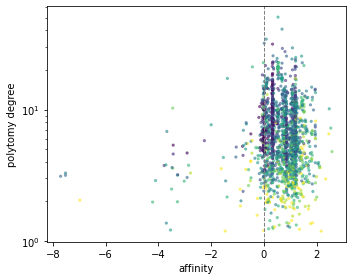

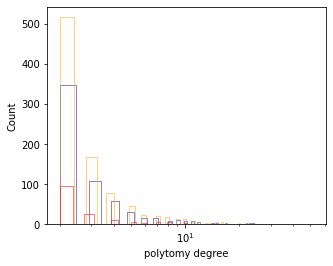

In [11]:
# df = df[df.divergence > 5]

plt.figure(figsize=(5, 4))
plt.scatter(x=df.affinity, y=df["LBI"], c=df.divergence,
            alpha=0.5,
            s=5,
            vmax=10,
           )
plt.axvline(0, c="grey", ls="--", lw=1)
plt.xlabel(r"affinity")
plt.ylabel("polytomy degree")
plt.yscale("log")

plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
sns.histplot(data=df[df.affinity > 1], x="polytomy degree", color="b", fill=False)
sns.histplot(data=df[(df.affinity < 1) & (df.affinity > 0)], x="polytomy degree", color="orange", fill=False)
sns.histplot(data=df[(df.affinity < 0)], x="polytomy degree", color="r", fill=False)
plt.xscale("log")
plt.show()

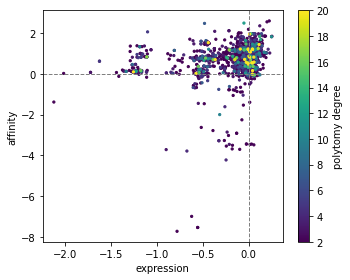

In [234]:
plt.figure(figsize=(5, 4))
plt.scatter(x=df[r"expression"], y=df[r"affinity"],
            c=df["polytomy degree"],
            s=5,
            vmax=20,
           )
plt.axvline(0, c="grey", ls="--", lw=1)
plt.axhline(0, c="grey", ls="--", lw=1)
plt.ylabel(r"affinity")
plt.xlabel(r"expression")
plt.colorbar(label="polytomy degree")

plt.tight_layout()
plt.show()

# sns.violinplot(data=df, y=r"affinity", x=f"LBR $\geq$ {thresh}")
# plt.axhline(0, c="grey", ls="--", lw=1)

# plt.tight_layout()
# plt.savefig("output/plots/affinity-fitness.LBR_Vs_bind.pdf")
# plt.show()

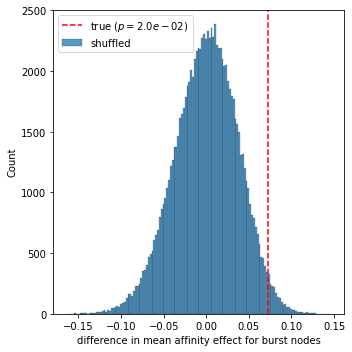

In [12]:
delta_mean = df.loc[df["burst"]==True, r"parent edge $\Delta$ affinity"].mean() - df.loc[df["burst"]==False, r"parent edge $\Delta$ affinity"].mean()
delta_mean_sim = []
n_sim = 100000
burst_idxs = df["burst"] == True
affinities = df[r"parent edge $\Delta$ affinity"].values
for _ in range(n_sim):
    shuffled_idxs = np.random.permutation(df.index)
    shuffled_affinities = affinities[shuffled_idxs]    
    delta_mean_sim.append(shuffled_affinities[burst_idxs].mean() - shuffled_affinities[~burst_idxs].mean())

p = sum(x >= delta_mean for x in delta_mean_sim) / n_sim

plt.figure(figsize=(5, 5))
sns.histplot(x=delta_mean_sim, label="shuffled")
plt.axvline(delta_mean, c="r", ls="--", label=f"true ($p={p:.1e}$)")
plt.legend()
plt.xlabel(f"difference in mean affinity effect for burst nodes")
plt.tight_layout()
plt.savefig("output/plots/affinity-fitness.pvalue.pdf")
plt.show()

## Permissive mutations below burst nodes?

In [122]:
rows = []
burst_thresh = 10
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        if not node.is_root():# and node.dist == 1:
            delta_delta_bind = node.delta_bind_CGG - node.up.delta_bind_CGG
            delta_delta_expr = node.delta_expr - node.up.delta_expr
            parent_polytomy_degree = len(node.up.children) + node.up.abundance
            new_mutations = ",".join(set(node.mutations) - set(node.up.mutations))
            reverted_mutations = ",".join(set(node.up.mutations) - set(node.mutations))
            rows.append([gc, node.name, node.dist, node.abundance, new_mutations, reverted_mutations, parent_polytomy_degree, parent_polytomy_degree > burst_thresh, delta_delta_bind, delta_delta_expr])
df = pd.DataFrame(rows, columns=["GC", "name", "branch length", "abundance", "new mutations", "reverted mutations", "parent polytomy degree", "parent burst", r"$\Delta\Delta$ affinity", r"$\Delta\Delta$ expression"])

# no 10-week
df = df.loc[~df.GC.str.startswith("mouse7") & ~df.GC.str.startswith("mouse8")]

df

,GC,name,branch length,abundance,new mutations,reverted mutations,parent polytomy degree,parent burst,$\Delta\Delta$ affinity,$\Delta\Delta$ expression
0,mouse1_GC1,seq37,4.0,1,"S20(L)N,L116(L)P,Y103(H)F",,5,False,-0.06082,0.14827
1,mouse1_GC1,seq47,11.0,1,"Q95(L)E,E51(H)G,N108(L)K,V71(L)I,D74(L)A,Y66(L...",,5,False,-3.45668,-1.05627
2,mouse1_GC1,seq56,1.0,1,Y58(H)D,,5,False,-0.80796,-0.15104
3,mouse1_GC1,1,4.0,0,"N40(H)H,E125(L)Q,N108(L)D,Y114(L)S",,5,False,-7.71074,-0.77924
4,mouse1_GC1,17,1.0,0,A105(H)G,,5,False,0.33100,-0.00561
...,...,...,...,...,...,...,...,...,...,...
5507,mouse6_GC77,seq2,2.0,3,L89(H)V,,3,False,-0.10438,-0.04884
5508,mouse6_GC77,seq25,2.0,1,,,2,False,0.00000,0.00000
5509,mouse6_GC77,seq43,1.0,1,S109(L)N,,2,False,-0.03494,-0.14250
5510,mouse6_GC77,seq58,1.0,1,Y103(H)F,,4,False,0.04243,-0.01071


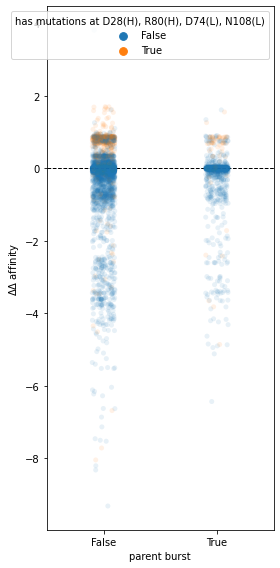

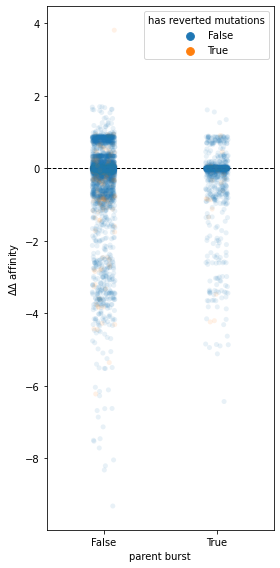

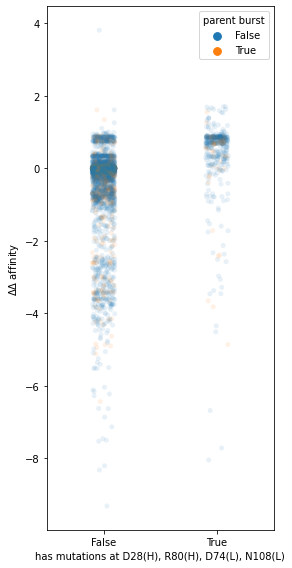

In [128]:
# see mutations nb
df["has mutations at D28(H), R80(H), D74(L), N108(L)"] = (
                             (df["new mutations"].str.contains("D28(H)", regex=False)) |
                             (df["new mutations"].str.contains("R80(H)", regex=False)) |
                             (df["new mutations"].str.contains("D74(L)", regex=False)) |
                             (df["new mutations"].str.contains("N108(L)", regex=False))
                            )

df["has reverted mutations"] = df["reverted mutations"].str.len() > 0

plt.figure(figsize=(4, 8))
sns.stripplot(data=df, y=r"$\Delta\Delta$ affinity", x="parent burst", hue="has mutations at D28(H), R80(H), D74(L), N108(L)", alpha=0.1)
plt.axhline(0, c="k", lw=1, ls="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 8))
sns.stripplot(data=df, y=r"$\Delta\Delta$ affinity", x="parent burst", hue="has reverted mutations", alpha=0.1)
plt.axhline(0, c="k", lw=1, ls="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 8))
sns.stripplot(data=df, y=r"$\Delta\Delta$ affinity", x="has mutations at D28(H), R80(H), D74(L), N108(L)", hue="parent burst", alpha=.1)
# plt.axvline(0, c="k", lw=1, ls="--")
plt.tight_layout()
plt.show()

In [97]:
from collections import Counter
Counter([x[:-1] for x in ",".join(df.loc[np.abs(df[r"$\Delta\Delta$ affinity"] - 0.8) < 0.1]["new mutations"]).split(",")])

Counter({'A40(L)': 50,
         'T96(H)': 13,
         'K51(L)': 5,
         'S64(H)': 67,
         'D28(H)': 34,
         'S109(L)': 81,
         'K49(H)': 5,
         'N85(H)': 2,
         'S20(L)': 2,
         'S57(H)': 13,
         'N108(L)': 150,
         'L124(L)': 4,
         'Q105(L)': 2,
         'T37(L)': 2,
         'L50(H)': 3,
         'L89(L)': 2,
         'D74(L)': 1,
         'V39(L)': 2,
         'N93(L)': 8,
         'E101(L)': 4,
         'K72(H)': 1,
         'N92(H)': 8,
         'Y42(L)': 16,
         'T35(H)': 1,
         'Y67(H)': 4,
         'S74(H)': 2,
         'R67(L)': 8,
         'T65(H)': 9,
         'Y66(L)': 5,
         'K45(L)': 4,
         'V15(L)': 4,
         'K123(L)': 5,
         'A52(L)': 16,
         'M11(L)': 3,
         'I126(L)': 6,
         'N40(H)': 3,
         'L4(H)': 1,
         'T82(H)': 2,
         'Q86(H)': 5,
         'L116(L)': 4,
         'T90(L)': 2,
         'T95(H)': 2,
         'Q90(H)': 3,
         'S120(L)': 1,
         'S92(

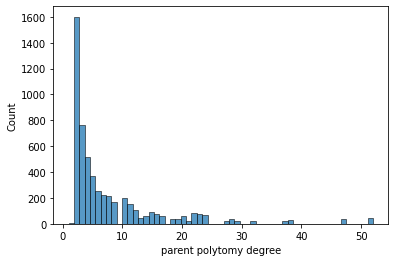

In [25]:
sns.histplot(df, x="parent polytomy degree")
plt.show()

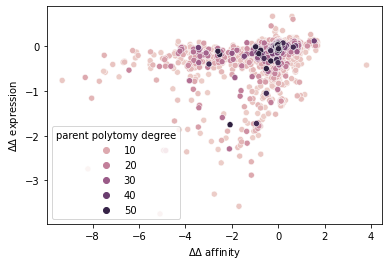

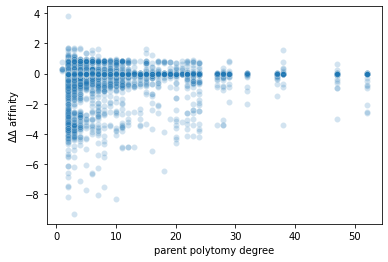

In [103]:
# plt.scatter(df["branch length"], df[r"$\Delta\Delta$ affinity"], c=df["parent polytomy degree"])
# plt.scatter(df["parent polytomy degree"], df[r"$\Delta\Delta$ affinity"])
sns.scatterplot(data=df.sort_values("parent polytomy degree"), x=r"$\Delta\Delta$ affinity", y=r"$\Delta\Delta$ expression", hue="parent polytomy degree")
plt.show()

sns.scatterplot(data=df, y=r"$\Delta\Delta$ affinity", x="parent polytomy degree", alpha=0.2)
# plt.xscale("log")
plt.show()

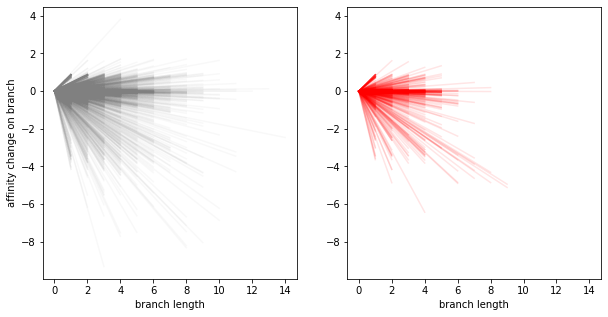

In [27]:
df_burst = df.loc[df["parent burst"]]
df_not_burst = df.loc[~df["parent burst"]]

plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
plt.plot([[0] * len(df_not_burst), df_not_burst["branch length"]], [[0] * len(df_not_burst), df_not_burst[r"$\Delta\Delta$ affinity"]],
         color="grey", alpha=0.05)
plt.xlabel("branch length")
plt.ylabel("affinity change on branch")

plt.subplot(122, sharex=ax, sharey=ax)
plt.plot([[0] * len(df_burst), df_burst["branch length"]], [[0] * len(df_burst), df_burst[r"$\Delta\Delta$ affinity"]],
         color="red", alpha=0.1)
plt.xlabel("branch length")
plt.show()

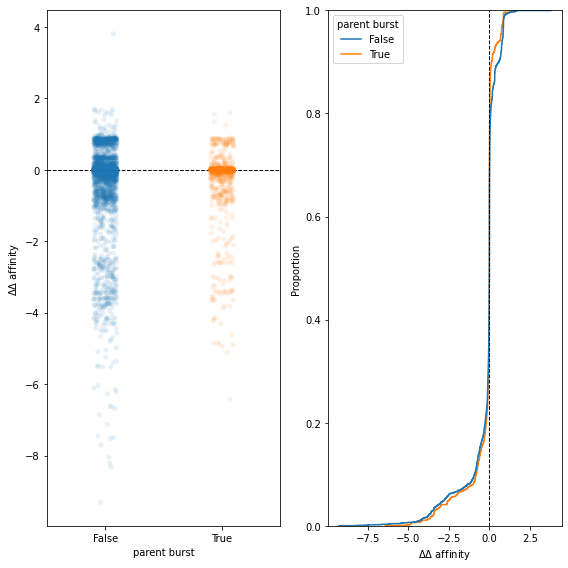

In [28]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
sns.stripplot(data=df, y=r"$\Delta\Delta$ affinity", x="parent burst", alpha=0.1)
plt.axhline(0, c="k", lw=1, ls="--")

plt.subplot(122)
sns.ecdfplot(data=df, x=r"$\Delta\Delta$ affinity", hue="parent burst")
plt.axvline(0, c="k", lw=1, ls="--")

plt.tight_layout()
plt.show()

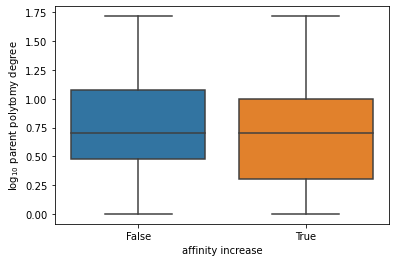

,parent is not a burst,parent is a burst
not affinity increase,1025,406
affinity increase,500,156


χ2 = 4.59, p = 0.032


In [292]:
df["affinity increase"] = df[r"$\Delta\Delta$ affinity"] > 0
df[r"$\log_{10}$ parent polytomy degree"] = np.log10(df["parent polytomy degree"])

sns.boxplot(data=df, x="affinity increase", y=r"$\log_{10}$ parent polytomy degree")
plt.show()

contingency = pd.DataFrame([[sum(~df["affinity increase"] & ~df["parent burst"]), sum(~df["affinity increase"] & df["parent burst"])],
                   [sum(df["affinity increase"] & ~df["parent burst"]), sum(df["affinity increase"] & df["parent burst"])]],
                  index=["not affinity increase", "affinity increase"], columns=["parent is not a burst", "parent is a burst"])
display(contingency)

from scipy.stats import chi2_contingency
chi2, p = chi2_contingency(contingency)[:2]
print(f"χ2 = {chi2:.2f}, p = {p:.3f}")

## Are single mutation edges below bursts unselected (compared to neutral sim)?

In [294]:
def mutate(sequence):
    sequence_H = "NN" + sequence[:igk_idx] + "NN"
    sequence_K = "NN" + sequence[igk_idx:] + "NN"
    # mutabilities of each nucleotide
    contexts = [sequence_H[(i - 2) : (i + 3)]
                    for i in range(2, len(sequence_H) - 2)
                   ] + [sequence_K[(i - 2) : (i + 3)]
                        for i in range(2, len(sequence_K) - 2)
                       ]
    mutabilities = np.array([mutability[context] for context in contexts])
    i = np.random.choice(len(mutabilities), p=mutabilities / sum(mutabilities))
    sequence = sequence[:i] + np.random.choice(substitution.columns, p=substitution.loc[contexts[i]].fillna(0)) + sequence[(i + 1):]
    return sequence

def aa(seq, frame):
    return Seq(seq[(frame - 1) : (frame - 1 + (3 * ((len(seq) - (frame - 1)) // 3)))]).translate()

def mutations(naive_aa, aa, pos_map, chain_annotation):
    return [f"{aa1}{pos_map[pos]}{chain_annotation}{aa2}"
            for pos, (aa1, aa2) in enumerate(zip(naive_aa, aa))
            if aa1 != aa2]

In [299]:
from Bio.Seq import Seq

mutability = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_mutability.csv", sep=" ", index_col=0).squeeze("columns")
substitution = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=" ", index_col=0)

naive = next(iter(trees.values())).tree.sequence
igh_frame = 1
igk_frame = 1
igk_idx = 336

naive_igh_aa = aa(naive[:igk_idx], igh_frame)
naive_igk_aa = aa(naive[igk_idx:], igk_frame)

In [308]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]

In [309]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

### collect burst node polytomies

In [310]:
burst_nodes = []
burst_thresh = 10
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        polytomy_degree = len(node.children) + node.abundance
        if polytomy_degree > burst_thresh:
            node_copy = node.copy("deepcopy")
            for child in node_copy.children:
                for grandchild in child.children:
                    child.remove_child(grandchild)
            burst_nodes.append(node_copy)

### simulated version of each burst polytomy

In [320]:
simulated_burst_nodes = []
for node in burst_nodes:
    simulated_node = node.copy(method="deepcopy")
    for child in simulated_node.children:
        child.sequence = simulated_node.sequence
        for _ in range(int(child.dist)):
            child.sequence = mutate(child.sequence)
            igh_aa = aa(child.sequence[:igk_idx], igh_frame)
            igk_aa = aa(child.sequence[igk_idx:], igk_frame)
            igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
            igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")        
            all_mutations = igh_mutations + igk_mutations
            if any("*" in x for x in all_mutations):
                child.delta_bind = np.nan
                child.delta_expr = np.nan
                child.delta_psr = np.nan
            else:
                child.delta_bind = dms_df.delta_bind[all_mutations].sum()
                child.delta_expr = dms_df.delta_expr[all_mutations].sum()
                child.delta_psr = dms_df.delta_psr[all_mutations].sum()
    
    
    simulated_burst_nodes.append(simulated_node)

In [331]:
rows = []
for burst_node, simulated_burst_node in zip(burst_nodes, simulated_burst_nodes):
    for child in burst_node.children:
        # NOTE: only single-mutant edges here
        if child.dist == 1:
            delta_delta_bind = child.delta_bind - child.up.delta_bind
            delta_delta_expr = child.delta_expr - child.up.delta_expr
            rows.append(["real", delta_delta_bind, delta_delta_expr])
    for child in simulated_burst_node.children:
        # NOTE: only single-mutant edges here
        if child.dist == 1:
            delta_delta_bind = child.delta_bind - child.up.delta_bind
            delta_delta_expr = child.delta_expr - child.up.delta_expr
            rows.append(["simulation", delta_delta_bind, delta_delta_expr])
df = pd.DataFrame(rows, columns=["data", r"$\Delta\Delta$ affinity", r"$\Delta\Delta$ expression"])
df

,data,$\Delta\Delta$ affinity,$\Delta\Delta$ expression
0,real,0.02258,-0.02185
1,real,0.00000,0.00000
2,real,NaN,NaN
3,real,-0.02327,0.04704
4,simulation,0.00000,0.00000
...,...,...,...
1165,simulation,0.00173,-0.11121
1166,real,-3.64157,-0.12243
1167,real,0.00000,0.00000
1168,simulation,0.01228,-0.02823


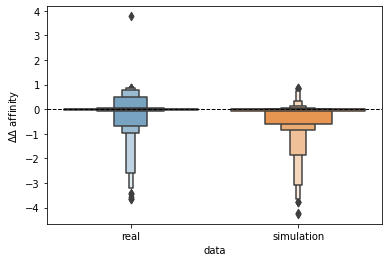

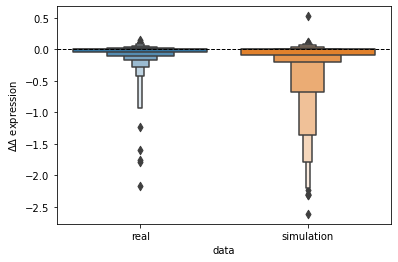

In [333]:
sns.boxenplot(data=df, y=r"$\Delta\Delta$ affinity", x="data")
plt.axhline(0, ls="--", c="k", lw=1)
plt.show()

sns.boxenplot(data=df, y=r"$\Delta\Delta$ expression", x="data")
plt.axhline(0, ls="--", c="k", lw=1)
plt.show()